# Offside

## Introduction, Reference Domain, and Objectives
The Offside project starts from the need of creating a recommendation system based on machine learning which, given a football player, returns a series of players as similar as possible based on a set of technical-tactical data. The reference domain is, obviously, the world of football, and the reference platform for data retrieval is Fbref, a consultation source that includes data relating to players, teams and championships in an easily to consult, -and scrape-, fashion.

The approach that the project intends to adopt is based on a rather simple notion: let's assume we have a two-dimensional Cartesian plane, where each point corresponds to a player based on a pair of technical characteristics of our choice. The players most similar to the original player will be those who have the smallest distance on the Cartesian plane. It is sufficient to raise the plane to n dimensions, one for each of the technical attributes considered, to evaluate the similarity of the players on the hyperplane. The only caveat is that calculating the distance on a n-dimensional plane requires a little bit more effort than doing the same thing for a bi-dimensional plane, but thanks to the use of the Euclidean distance, the problem will be solved quite easily. In the code block that follows, we will begin by importing all the necessary libraries for the model.

In [20]:
# Import necessary libraries
import random
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

## Data Retrieval, Parsing, Preparation, Cleaning, and Optimization
This section aims to retrieve data from multiple web URLs, each pointing to a webpage on FBref, a website providing comprehensive football statistics and tables. The `leagues_urls` dictionary contains URLs for different football leagues, and the code iterates through this dictionary to scrape data for each league.

The `pd.read_html()` function is utilized to parse the HTML content of the webpages and extract tables. Before parsing, the `.replace()` method is employed to remove HTML comment tags ('<!--' and '-->') from the webpage content. This ensures that the HTML can be imported correctly and without hidden elements ruining the formatting, allowing `read_html()` to parse it effectively. This workaround was sourced from a StackOverflow discussion (https://stackoverflow.com/questions/77548912/how-to-extract-table-from-a-webpage-using-its-id).

For each league, the `pd.read_html()` function call fetches the HTML content using `requests.get(url).text`, which is then passed to `read_html()` for parsing. The `attrs` parameter specifies the HTML attribute `id` of the table element to be extracted, which is 'stats_standard', a table containing player attributes. The `[0]` index is used to select the first table matching the specified attributes.

After scraping the data, we prepare it for further analysis and processing. Column names are redefined to enhance clarity and comprehension of the dataset. These new column names categorize various aspects of player information, performance metrics, and expected outcomes. Following the renaming process, the data types of specific columns are adjusted for consistency and suitability for analysis. String columns are converted to the string data type, while categorical columns are converted to the categorical data type for efficient storage and computation. Additionally, numerical data columns are converted to numeric types, with appropriate error handling for inconsistencies or invalid entries. Given that the model will be based on the computation of n-Dimensional Euclidean Distance (with n being the number of attributes considered), having accurate numerical values is crucial for precision and consistency.

Unnecessary information is removed from the dataset to streamline its structure and optimize analytical processes. Columns such as alphabetical rank and nationality are deemed irrelevant for the intended analysis and thus removed. Similarly, redundant columns are eliminated, including the age attribute (since the year of birth is already provided) and a redundant hyperlink column (the last column, which is a hyperlink provided by FBref). The processed dataset is then exported to a CSV file named `"players.csv"` to facilitate future analysis and sharing. Below is a description of the dataset columns as provided by the website.

### Dataset Columns Explanation

#### Background Information
1. **(Background Information, Full Name)**: indicates the full name of the player
2. **(Background Information, Position)**: specifies the primary position of the player
3. **(Background Information, Squad)**: denotes the squad the player belongs to
4. **(Background Information, Year of Birth)**: indicates the year of birth of the player
5. **(Background Information, League)**: denotes the league the player is associated with

#### Playing Time
6. **(Playing Time, MP)**: stands for Matches Played
7. **(Playing Time, Starts)**: denotes the number of matches started by the player
8. **(Playing Time, Min)**: represents the total minutes played by the player
9. **(Playing Time, 90s)**: indicates the total minutes played divided by 90

#### Performance
10. **(Performance, Gls)**: represents the number of goals scored by the player
11. **(Performance, Ast)**: denotes the number of assists made by the player
12. **(Performance, G+A)**: indicates the total number of goals and assists combined
13. **(Performance, G-PK)**: represents the number of goals scored excluding penalty kicks
14. **(Performance, PK)**: denotes the number of penalty kicks scored by the player
15. **(Performance, PKatt)**: represents the number of penalty kicks attempted by the player
16. **(Performance, CrdY)**: indicates the number of yellow cards received by the player
17. **(Performance, CrdR)**: denotes the number of red cards received by the player

#### Expected
18. **(Expected, xG)**: represents the expected goals for the player
19. **(Expected, npxG)**: denotes the non-penalty expected goals for the player
20. **(Expected, xAG)**: represents the expected assists for the player
21. **(Expected, npxG+xAG)**: indicates the sum of non-penalty expected goals and expected assists

#### Progression
22. **(Progression, PrgC)**: stands for progressive carries made by the player
23. **(Progression, PrgP)**: denotes progressive passes made by the player
24. **(Progression, PrgR)**: represents progressive carries made by the player

#### Per 90 Minutes
25. **(Per 90 Minutes, Gls)**: represents the average number of goals scored per 90 minutes
26. **(Per 90 Minutes, Ast)**: denotes the average number of assists made per 90 minutes
27. **(Per 90 Minutes, G+A)**: indicates the average number of goals and assists combined per 90 minutes
28. **(Per 90 Minutes, G-PK)**: represents the average number of goals scored excluding penalty kicks per 90 minutes
29. **(Per 90 Minutes, G+A-PK)**: denotes the average number of goals and assists combined excluding penalty kicks per 90 minutes
30. **(Per 90 Minutes, xG)**: represents the average expected goals per 90 minutes
31. **(Per 90 Minutes, xAG)**: denotes the average expected assists per 90 minutes
32. **(Per 90 Minutes, xG+xAG)**: indicates the average sum of expected goals and expected assists per 90 minutes
33. **(Per 90 Minutes, npxG)**: represents the average non-penalty expected goals per 90 minutes
34. **(Per 90 Minutes, npxG+xAG)**: denotes the average sum of non-penalty expected goals and expected assists per 90 minutes

These columns collectively provide a comprehensive overview of player performance, background, and progression metrics, facilitating in-depth analysis and insights as the further progression of the model will demonstrate.

In [21]:
# Dictionary of league URLs
leagues_urls = {
    "Serie A": 'https://fbref.com/en/comps/11/stats/Serie-A-Stats',
    "Premier League": 'https://fbref.com/en/comps/9/stats/Premier-League-Stats',
    "Bundesliga": 'https://fbref.com/en/comps/20/stats/Bundesliga-Stats',
    "La Liga": 'https://fbref.com/en/comps/12/stats/La-Liga-Stats',
    "Ligue 1": 'https://fbref.com/en/comps/13/stats/Ligue-1-Stats',
    "Eredivisie": 'https://fbref.com/en/comps/23/stats/Eredivisie-Stats'
}

# Set your desired league filter
league_filter = ["Serie A", 
                 "Premier League", 
                 "Bundesliga", 
                 "La Liga", 
                 "Ligue 1", 
                 "Eredivisie"
                 ]

# Initialization of an empty list to hold DataFrames
dfs = []

# Iteration through the league URLs dictionary
for league, url in leagues_urls.items(): 
    if 'league_filter' in locals() and league not in league_filter:
        continue  # Skip if the league is not in the league_filter list
    # Utilize the pandas library to read the HTML content from the specified URL
    # Replace HTML comments to ensure proper parsing of the content
    # Extract the data table with specified attributes
    df = pd.read_html(
        requests.get(url).text.replace('<!--','').replace('-->','')
        ,attrs={'id':'stats_standard'}
    )[0]

    # Definition of new column names to be used for the DataFrame
    new_columns = [
        "(Background Information, Alphabetical Rank)",
        "(Background Information, Full Name)",
        "(Background Information, Nation)",
        "(Background Information, Position)",
        "(Background Information, Squad)",
        "(Background Information, Age)",
        "(Background Information, Year of Birth)",
        "(Playing Time, MP)",
        "(Playing Time, Starts)",
        "(Playing Time, Min)",
        "(Playing Time, 90s)",
        "(Performance, Gls)",
        "(Performance, Ast)",
        "(Performance, G+A)",
        "(Performance, G-PK)",
        "(Performance, PK)",
        "(Performance, PKatt)",
        "(Performance, CrdY)",
        "(Performance, CrdR)",
        "(Expected, xG)",
        "(Expected, npxG)",
        "(Expected, xAG)",
        "(Expected, npxG+xAG)",
        "(Progression, PrgC)",
        "(Progression, PrgP)",
        "(Progression, PrgR)",
        "(Per 90 Minutes, Gls)",
        "(Per 90 Minutes, Ast)",
        "(Per 90 Minutes, G+A)",
        "(Per 90 Minutes, G-PK)",
        "(Per 90 Minutes, G+A-PK)",
        "(Per 90 Minutes, xG)",
        "(Per 90 Minutes, xAG)",
        "(Per 90 Minutes, xG+xAG)",
        "(Per 90 Minutes, npxG)",
        "(Per 90 Minutes, npxG+xAG)"
    ] + list(df.columns[36:])  

    # Assign the new column names to the DataFrame
    df.columns = new_columns

    # Conversion of specific columns to appropriate data types
    df["(Background Information, Full Name)"] = df["(Background Information, Full Name)"].astype("string")
    df["(Background Information, Position)"] = df["(Background Information, Position)"].astype("category")
    df["(Background Information, Squad)"] = df["(Background Information, Squad)"].astype("category")

    # List of numerical columns to convert to numeric data type
    numerical_columns_to_convert = [
        "(Background Information, Year of Birth)",
        "(Playing Time, MP)",
        "(Playing Time, Starts)",
        "(Playing Time, Min)",
        "(Playing Time, 90s)",
        "(Performance, Gls)",
        "(Performance, Ast)",
        "(Performance, G+A)",
        "(Performance, G-PK)",
        "(Performance, PK)",
        "(Performance, PKatt)",
        "(Performance, CrdY)",
        "(Performance, CrdR)",
        "(Expected, xG)",
        "(Expected, npxG)",
        "(Expected, xAG)",
        "(Expected, npxG+xAG)",
        "(Progression, PrgC)",
        "(Progression, PrgP)",
        "(Progression, PrgR)",
        "(Per 90 Minutes, Gls)",
        "(Per 90 Minutes, Ast)",
        "(Per 90 Minutes, G+A)",
        "(Per 90 Minutes, G-PK)",
        "(Per 90 Minutes, G+A-PK)",
        "(Per 90 Minutes, xG)",
        "(Per 90 Minutes, xAG)",
        "(Per 90 Minutes, xG+xAG)",
        "(Per 90 Minutes, npxG)",
        "(Per 90 Minutes, npxG+xAG)"
    ]

    # Conversion of specified columns to numeric data type
    for col in numerical_columns_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Removal of unnecessary columns from the DataFrame
    df.drop('(Background Information, Alphabetical Rank)', axis=1, inplace=True)
    df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

    # Addition of the league column to the DataFrame
    df["(Background Information, League)"] = league

    # Append the DataFrame to the initial DataFrame list
    dfs.append(df)

# Concatenation of DataFrames obtained from all leagues
df = pd.concat(dfs, ignore_index=True)

# Remove rows with missing values
df.dropna(inplace=True)

# Export the processed DataFrame to a CSV file
df.to_csv("Exports/Tables/players.csv", encoding='utf-8', index=False)

# Return the modified DataFrame
df

,"(Background Information, Full Name)","(Background Information, Nation)","(Background Information, Position)","(Background Information, Squad)","(Background Information, Age)","(Background Information, Year of Birth)","(Playing Time, MP)","(Playing Time, Starts)","(Playing Time, Min)","(Playing Time, 90s)",...,"(Per 90 Minutes, Ast)","(Per 90 Minutes, G+A)","(Per 90 Minutes, G-PK)","(Per 90 Minutes, G+A-PK)","(Per 90 Minutes, xG)","(Per 90 Minutes, xAG)","(Per 90 Minutes, xG+xAG)","(Per 90 Minutes, npxG)","(Per 90 Minutes, npxG+xAG)","(Background Information, League)"
0,Tammy Abraham,eng ENG,FW,Roma,25,1997.0,8.0,2.0,242.0,2.7,...,0.00,0.37,0.37,0.37,0.22,0.05,0.27,0.22,0.27,Serie A
1,Francesco Acerbi,it ITA,DF,Inter,35,1988.0,29.0,26.0,2388.0,26.5,...,0.04,0.15,0.11,0.15,0.06,0.07,0.13,0.06,0.13,Serie A
2,Yacine Adli,fr FRA,MF,Milan,23,2000.0,24.0,17.0,1407.0,15.6,...,0.13,0.19,0.06,0.19,0.02,0.14,0.16,0.02,0.16,Serie A
3,Michel Aebischer,ch SUI,MF,Bologna,26,1997.0,36.0,26.0,2230.0,24.8,...,0.04,0.04,0.00,0.04,0.04,0.06,0.11,0.04,0.11,Serie A
4,Lucien Agoume,fr FRA,MF,Inter,21,2002.0,1.0,0.0,5.0,0.1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Serie A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505,Lequincio Zeefuik,nl NED,"MF,FW",AZ Alkmaar,18,2004.0,6.0,0.0,59.0,0.7,...,1.53,1.53,0.00,1.53,0.25,0.51,0.76,0.25,0.76,Eredivisie
3506,Lequincio Zeefuik,nl NED,"FW,MF",Volendam,18,2004.0,16.0,8.0,773.0,8.6,...,0.12,0.47,0.35,0.47,0.23,0.11,0.33,0.23,0.33,Eredivisie
3507,Ramiz Zerrouki,dz ALG,MF,Feyenoord,25,1998.0,26.0,15.0,1387.0,15.4,...,0.00,0.00,0.00,0.00,0.02,0.12,0.14,0.02,0.14,Eredivisie
3508,Giovanni van Zwam,nl NED,DF,Vitesse,19,2004.0,12.0,3.0,492.0,5.5,...,0.00,0.00,0.00,0.00,0.05,0.01,0.05,0.05,0.05,Eredivisie


## Parametric Configuration, Algorithmic Definition, and Data Modelling

The following block of code is dedicated to the configuration of the model, which was designed to be as modular as possible in order to be reused according to the individual needs of sports data analysis professionals. In particular, the code first allows us to specify the name and surname of the player we intend to take as a reference. Simply pass a string to the code containing the name of the player contained in the Column `(Background Information, Full Name)`, for example `reference_player_name = "Francesco Acerbi"`. Obviously, the player must be present in the Table, otherwise an error will be thrown. We then have a role filter, called `role_filter`. If this variable is set to `None`, then no filter will be used and the search will take place taking the players' statistical differences as a guideline. If, however, we have a specific position in mind for which to scout a player, for example the goalkeeper, just write `role_filter = "GK"`, and all the players returned will be players with `"GK"` as the value of their `(Background Information, Position)` column. This can be particularly useful when the starting point of the search is a goalkeeper with good feet (i.e. Mike Maignan), who due to his high ability to generate assists, without the filter activated could be compared with defenders or midfielders

We then have the variable `number_of_players_returned`, which indicates the quantity of players that will be returned by the algorithm. By default, this parameter is set to 5, but you can change it to have a longer list of similarities. It goes without saying that the longer the list, the less similar the values at the bottom of the list are to the original player. We then have the `relevant_cols` Array, which contains a list chosen by the analyst of the attributes to be included in the Euclidean comparison of the players. The columns to be inserted must have the same name as the corresponding columns on the dataframe, paying careful attention to Case Sensitivity: uppercase and lowercase are treated differently, and this could cause errors. By default, the vast majority of the columns present have been selected, as this allows for an all-round analysis of the players and their respective comparisons between them. However, it is possible to remove or add values (simply by commenting the respective line) based on scouting needs. Finally, the variable `league_filter` allows the user to specify a list of leagues to be considered in the search. This filter ensures that only players from the specified leagues are included in the comparison. For example, setting `league_filter = ["Serie A", "Premier League", "Bundesliga", "La Liga", "Ligue 1", "Eredivisie"]` restricts the search to players in these top European leagues. 

In [24]:
"""
-* MODEL CONFIGURATION *-
The following block of code contains the configuration parameters of the model, designed for modularity in sports data analysis. 
It enables customization according to individual needs, so please follow this explanation of the editable values in order to make the best out of it.

1. reference_player_name: identifies the player to be brought up for comparison.
   Please provide the full name as listed in the dataset under the (Background Information, Full Name) column.

2. role_filter: specifies the positional filter. 
   If set to None, the algorithm compares players based on statistical differences. 
   If set to a specific role abbreviation, the search is narrowed down to players with the same position.
   Useful for focused searches, ensuring relevant comparisons.
   Definitions of player roles:
   None - No Filter Active 
   "GK" - Goalkeepers
   "DF" - Defenders
   "MF" - Midfielders
   "FW" - Forwards
   "FB" - Fullbacks
   "LB" - Left Backs
   "RB" - Right Backs
   "CB" - Center Backs
   "DM" - Defensive Midfielders
   "CM" - Central Midfielders
   "LM" - Left Midfielders
   "RM" - Right Midfielders
   "WM" - Wide Midfielders
   "LW" - Left Wingers
   "RW" - Right Wingers
   "AM" - Attacking Midfielders

3. number_of_players_returned: indicates the quantity of players returned by the algorithm.
   Default is set to 5 for concise output, but can be adjusted for more comprehensive lists.
   Note: Increasing the number may reduce similarity among listed players along the bottom of the list.
   
4. relevant_cols: contains the columns of the dataframe that are to be taken in consideration by the algorithm.
   A sensible default value has already been set, but can be adjusted if other scouting needs need to be met.
   
5. league_filter: this parameter is designed to refine player comparisons based on their performance in specific leagues.
    It allows users to specify one or more leagues from which player data will be considered for analysis.
    By setting league_filter to a list of league abbreviations, users can narrow down the comparison to players who have 
    participated in the specified leagues. This ensures that the analysis is tailored to the context of particular 
    football competitions, facilitating more relevant player assessments.
    Supported Leagues:
    "Serie A" 
    "Premier League" 
    "Bundesliga" 
    "La Liga" 
    "Ligue 1"
    "Eredivisie" 
"""

# Set your desired reference player's name
reference_player_name = "Yacine Adli"

# Set your desired role filter
role_filter = None

# Set your desired number of players to be returned 
number_of_players_returned = 10

# Set your desired relevant columns
relevant_cols = ["(Background Information, Position)", 
               "(Background Information, Year of Birth)",
               "(Playing Time, MP)",
               "(Playing Time, Starts)",
               "(Playing Time, Min)",
               "(Playing Time, 90s)",
               "(Performance, Gls)",
               "(Performance, Ast)",
               "(Performance, G+A)",
               "(Performance, G-PK)",
               "(Performance, PK)",
               "(Performance, PKatt)",
               "(Performance, CrdY)",
               "(Performance, CrdR)",
               "(Expected, xG)",
               "(Expected, npxG)",
               "(Expected, xAG)",
               "(Expected, npxG+xAG)",
               "(Progression, PrgC)",
               "(Progression, PrgP)",
               "(Progression, PrgR)",
               "(Per 90 Minutes, Gls)",
               "(Per 90 Minutes, Ast)",
               "(Per 90 Minutes, G+A)",
               "(Per 90 Minutes, G-PK)",
               "(Per 90 Minutes, G+A-PK)",
               "(Per 90 Minutes, xG)",
               "(Per 90 Minutes, xAG)",
               "(Per 90 Minutes, xG+xAG)",
               "(Per 90 Minutes, npxG)",
               "(Per 90 Minutes, npxG+xAG)"]

# Set your desired league filter
league_filter = ["Serie A", 
                 # "Premier League", 
                 # "Bundesliga", 
                 # "La Liga", 
                 # "Ligue 1", 
                 # "Eredivisie"
                 ]

After the data preparation and the configuration phase, we can finally enter the modelling phase. The data pre-processing begins with the removal of any rows containing missing values (`NaN`) from the DataFrame containing the football player data, as this will avoid potential errors down the line. Relevant columns (`relevant_cols`) are then selected in order to describe various aspects of the player such as background information, playing time, performance metrics, expected goals, progression, and statistics per 90 minutes. In order to facilitate the normalization process, only the numeric columns are retained from the array of containing the relevant columns. The data is then normalized for each column, in order to create a fairer distribution and result in the evaluation phase.

The real insight behind the construction of the Model is the idea of mapping football players in an n-dimensional plane, based on their statistics and technical characteristics. To do this, we use the Euclidean distance formula, which is applicable to vectors of any size. Instead of implementing it manually, we will use the SciPy `euclidean` Function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html), which we have already imported previously with `from scipy .spatial.distance import euclidean`. This formula can be used to calculate the distance between two points in n-dimensional space, and in our example it fits perfectly to the size of the vectors involved. So, whether the vectors are two-dimensional, three-dimensional or higher dimensional, the formula remains the same, and this allows us to reason at an n-dimensional level as we would have done at a two-dimensional level: neighboring points in space equal players with similar characteristics. For completeness, here is the Euclidean Formula used, where `u` and `v` are two vectors of dimension `n`

$$\text{euclidean}(\mathbf{u}, \mathbf{v}) = \sqrt{\sum_{i=1}^{n} (u_i - v_i)^2}$$

The code will compute the Euclidean distances between the provided reference player and all other players in the dataset, filtering by role if specified. The distances are stored in a dictionary where the keys represent player indices and the values represent their respective distances from the reference player. These distances are then sorted in ascending order. The players most similar to the reference player are extracted based on their ascending Euclidean distances, defined as `Delta` in the printed summary, to represent a numerical indicator of distance between the reference player and another player (the lower the delta value, the better the similarity). Finally, the results are printed, formatted for having good readability and insights. If a role filter is applied, a note is provided regarding its influence on the returned results, to avoid potential oversights. It is also good to mention the speed of execution. The Euclidean Distance using the following code can be calculated in `O(n)` time, where `n` is the dimension of the input vectors. This is because the calculation involves only sums, multiplications, and square roots, which can be performed in linear time with respect to the size of the vectors. Therefore, we can also decide to have a huge list of players returned to us, and everything will be calculated in a matter of milliseconds.

In [25]:
import os

#Function to print both to console and file with correct formatting
def print_and_write(file, text):
    print(text)
    file.write(text + "\n")

# Dropping rows with missing values to prevent errors
df.dropna(inplace=True)

# Selecting numeric columns
numeric_cols = df[relevant_cols].select_dtypes(include=['number'])

# Normalizing the data
normalized_df = (numeric_cols - numeric_cols.mean()) / numeric_cols.std()

# Determining the index of the row corresponding to the reference player
reference_player_index = df.index[df['(Background Information, Full Name)'] == reference_player_name][0]

# Calculating distances between the reference player and others
distances = {}
reference_player = normalized_df.loc[reference_player_index]

for i, player in normalized_df.iterrows():
    if i == reference_player_index:
        continue
    # Adding role filtering condition
    if role_filter is not None and df.loc[i]['(Background Information, Position)'] != role_filter:
        continue
    # Adding league filtering condition
    if df.loc[i]['(Background Information, League)'] not in league_filter:
        continue
    distances[i] = euclidean(reference_player, player)

# Sorting distances
sorted_distances = sorted(distances.items(), key=lambda x: x[1])

# Selecting top similar players
top_similar_players = sorted_distances[:number_of_players_returned]

# Create a directory containing the reference player name
os.makedirs(f"Exports/Reports/{reference_player_name}", exist_ok=True)

# Saving output to file
with open(f"Exports/Reports/{reference_player_name}/Report [{reference_player_name}].txt", "w") as report_file:
    # Printing header to both terminal and file
    header = ("The reference player is {}\n"
              "Below is a list of the players most similar to the player mentioned above,\n"
              "ordered from most to least similar via Euclidean distance sampling.\n\n".format(reference_player_name))
    print_and_write(report_file, header)

    # Printing role filter information to both terminal and file
    if role_filter is not None:
        role_info = ("Please note that the values returned by the model are filtered for the '{}' role.\n"
                     "You can change or remove the filter entirely in the algorithm configuration section at any time.\n\n".format(role_filter))
    else:
        role_info = ("Please note that the values returned by the model are not filtered by any role.\n"
                     "You can add or change the role filter in the algorithm configuration section at any time.\n\n")
    print_and_write(report_file, role_info)

    # Printing league filter information to both terminal and file
    if league_filter:
        league_info = ("The league filter is set to display the following teams: {}\n"
                       "You can also change this setting at any time in the Model Configuration Section.\n\n".format(", ".join(league_filter)))
    else:
        league_info = ("The league filter is not set. You can set it in the Model Configuration Section.\n\n")
    print_and_write(report_file, league_info)

    print('─' * 25 + "\n")
    report_file.write('─' * 25 + "\n\n")

    # Printing details of top similar players to both terminal and file
    index_number = 1
    for player_index, distance in top_similar_players:
        player_name = df.loc[player_index]['(Background Information, Full Name)']
        player_role = df.loc[player_index]['(Background Information, Position)']
        player_club = df.loc[player_index]['(Background Information, Squad)']
        player_age = df.loc[player_index]['(Background Information, Year of Birth)']

        player_info = ("Player #{}: {}\n"
                       "Role: {}\n"
                       "Team: {}\n"
                       "Born In: {}\n"
                       "Delta: {:.5f}\n\n".format(index_number, player_name, player_role, player_club, int(player_age), distance))

        print_and_write(report_file, player_info)

        index_number += 1
    
# Printing a completion message indicating successful report saving
print(f"Report generation completed. The report has been successfully saved to 'Exports/Reports/{reference_player_name}/Report [{reference_player_name}].txt'.")

The reference player is Yacine Adli
Below is a list of the players most similar to the player mentioned above,
ordered from most to least similar via Euclidean distance sampling.


Please note that the values returned by the model are not filtered by any role.
You can add or change the role filter in the algorithm configuration section at any time.


The league filter is set to display the following teams: Serie A
You can also change this setting at any time in the Model Configuration Section.


─────────────────────────

Player #1: Fabiano Parisi
Role: DF
Team: Fiorentina
Born In: 2000
Delta: 1.72735


Player #2: Mërgim Vojvoda
Role: DF
Team: Torino
Born In: 1995
Delta: 1.78936


Player #3: Mathías Olivera
Role: DF
Team: Napoli
Born In: 1997
Delta: 1.86867


Player #4: Benjamin Pavard
Role: DF
Team: Inter
Born In: 1996
Delta: 1.92088


Player #5: Răzvan Marin
Role: MF
Team: Empoli
Born In: 1996
Delta: 1.92943


Player #6: Jackson Tchatchoua
Role: DF
Team: Hellas Verona
Born In: 2001
D

## Data Visualisation and Plotting


To better understand the results obtained, we will exploit two different plotting techniques, the first will be a classic Horizontal Bar Plot, while the second will be a Radar Plot. Starting with the Bar Plot contained in the following code, this rather simple and intuitive to understand graph shows the results of the distance of the `n` players most similar to the player taken as reference. The x-axis of the graph shows the Delta, i.e. the distance coefficient between the reference player and the players most similar to him. The lower the value, the better the similarity between the two. The y-axis shows the name of the players, ordered from most to least similar to the player who gives the title to the table (in other words, the players are presented in ascending order based on the value of Delta). The color of the bars corresponding to the players displayed in the graph will be useful to visualize at a glance the team to which they belong, as shown in the legend. The primary purpose of this graph is to give a quick and shareable visualization of the result obtained by the algorithm, useful as a clarifying example for non-technical personnel who may need to use the information produced. However, this is not the most in-depth way of analyzing the differences, which is why it will not be the only view adopted.

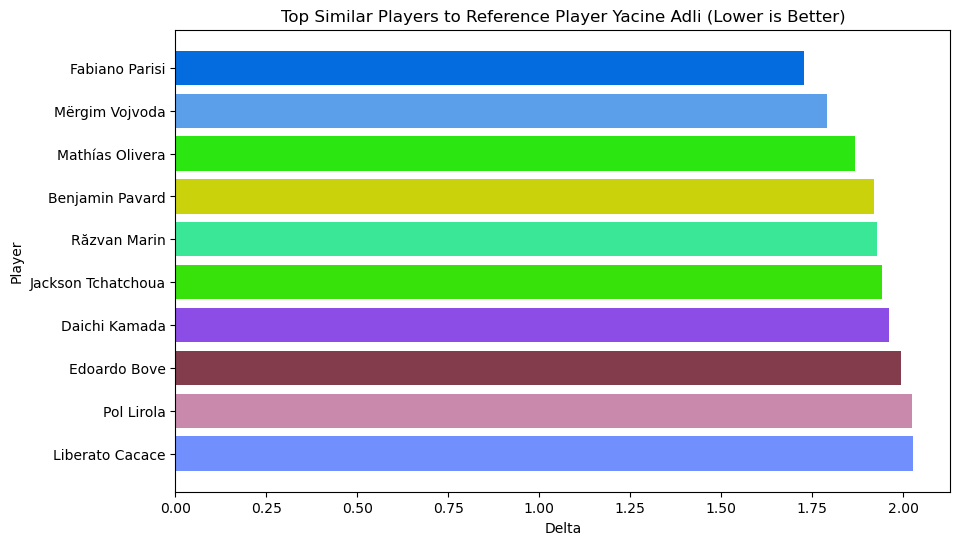

In [26]:
# Extracting player names and distances from the DataFrame
similar_player_names = [df.loc[player_index]['(Background Information, Full Name)'] for player_index, _ in top_similar_players]
similar_player_distances = [distance for _, distance in top_similar_players]

# Assigning random colors to players for visual distinction
player_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in similar_player_names]

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(similar_player_names, similar_player_distances, color=player_colors)

# Labeling axes and title
plt.xlabel('Delta')
plt.ylabel('Player')
plt.title(f'Top Similar Players to Reference Player {reference_player_name} (Lower is Better)')

# Inverting y-axis to display players with the highest similarity at the top
plt.gca().invert_yaxis()  

# Saving the plot as an image file
plt.savefig(f'Exports/Reports/{reference_player_name}/Delta Graph [{reference_player_name}].jpg', bbox_inches='tight')

# Displaying the plot
plt.show()

The real complication arising from plotting data beyond three dimensions comes from finding a compromise between making the data as comprehensible as possible, without at the same time giving up the depth and insights they offer. After an analysis of the graphs that can be created with Python (an excellent reference material in this regard is the Python Graph Gallery, that can be found at this URL: https://python-graph-gallery.com), it was clear that the best choice for the problem at hand was the Radar Plot, also known as Spider Plot or Polar Chart. The Plot contained in the following code block was created using MatPlotLib (the documentation used to build the next code block can be found on https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html, and scattered around StackOverflow Threads and Online Forums), through the creation of the `radar_plot` function. This function takes as input several parameters `player_names`, `player_data`, `reference_data`, `attribute_labels`, and `reference_player_name`. Using the values contained in them, it constructs an informative display, complete with legend. This is by far the most useful graph, as it allows you to observe multivariate data in a clear and efficient way, allowing easy comparison of players based on their attributes. 

The way the Calculation Model is structured generates an interesting graphical phenomenon. As long as you keep the list of suggested players within responsible limits, the plotting creates a clear silhouette of their areas of excellence, -or lack-. Since the model calculates the delta via Euclidean distance, the resulting plots are denoted by a similar shape and distribution within the radar space. Furthermore, such a visualization allows you to focus at a glance on attributes that may be more interesting than others. For example, you can focus on the number of assists you expect, find the player who has the most playing time, or even find the player most capable of scoring goals; and in the list of proposed players find the one who is considered best in that aspect. In this way, the graph not only highlights the actual similarity of the players compared to the reference player, but also proves to be a valuable tool in moments when it is necessary to make an informed decision based on the available data.

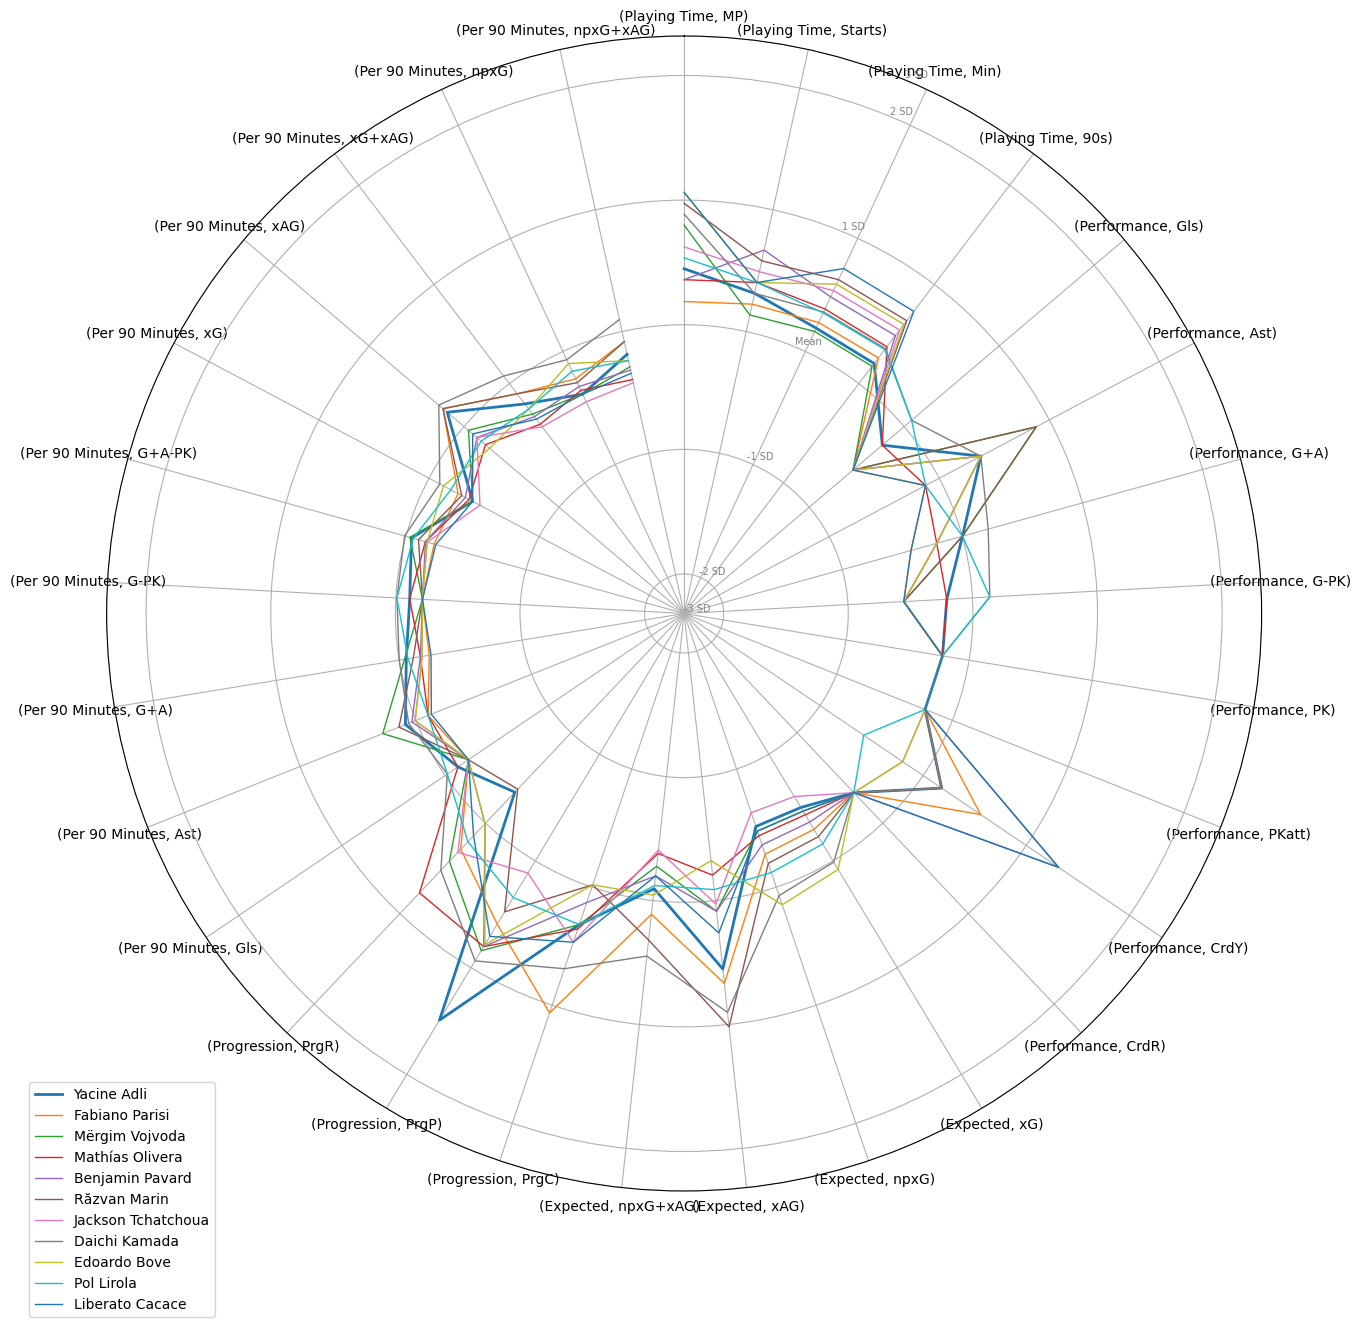

In [27]:
# Removing irrelevant columns from the dataset
relevant_cols.remove("(Background Information, Position)")
relevant_cols.remove("(Background Information, Year of Birth)")

def radar_plot(player_names, player_data, reference_data, attribute_labels, reference_player_name):
    # Converting attribute labels to numpy array for manipulation
    labels = np.array(attribute_labels)
    num_vars = len(labels)

    # Computing angles for radar chart axes
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Creating a figure and a set of subplots with polar projection
    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Setting ticks and labels for each angle (attribute)
    ax.set_xticks(angles)
    ax.set_xticklabels(attribute_labels)

    # Setting radial scale with logarithmic scaling
    ax.set_rscale('symlog')
    plt.yticks([-3, -2, -1, 0, 1, 2, 3], ["-3 SD", "-2 SD", "-1 SD", "Mean", "1 SD", "2 SD", "3 SD"], color="grey", size=7)
    plt.ylim(-3, 3)

    # Plotting radar charts for each player's data
    for i in range(len(player_names)):
        stats = player_data[i]
        if player_names[i] == reference_player_name:
            reference_stats = reference_data
            ax.plot(angles, reference_stats, linewidth=2, linestyle='solid', label=player_names[i])
        else:
            ax.plot(angles, stats, linewidth=1, linestyle='solid', label=player_names[i])

    # Adding a legend to the plot
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.savefig(f'Exports/Reports/{reference_player_name}/Extended Radar Plot [{reference_player_name}].jpg', bbox_inches='tight')

    # Displaying the radar plot
    return plt.show()

# Extracting player names and normalized data for plotting
player_names = [df.loc[player_index]['(Background Information, Full Name)'] for player_index, _ in top_similar_players]
player_data = [normalized_df.loc[player_index][relevant_cols] for player_index, _ in top_similar_players]

# Extracting reference player's index and data
reference_player_index = df[df['(Background Information, Full Name)'] == reference_player_name].index[0]
reference_data = normalized_df.loc[reference_player_index][relevant_cols]

# Inserting reference player's name and data to the beginning of lists
player_names.insert(0, reference_player_name)
player_data.insert(0, reference_data)

# Setting attribute labels
attribute_labels = relevant_cols

# Generating radar plot
radar_plot(player_names, player_data, reference_data, attribute_labels, reference_player_name)

## Export Comparison Data to CSV File

The Python code snippet provided above defines a function named `export_comparison_csv` aimed at exporting comparison data to a CSV (Comma-Separated Values) file. The function takes several parameters including `player_names`, `player_data`, `attribute_labels`, `reference_player_name`, and `df`, representing the names of players, their corresponding data, labels for attributes, the name of the reference player, and a DataFrame respectively. The function begins by initializing a list `all_attributes` which contains a comprehensive list of attributes categorized into various sections such as background information, playing time, performance, expected statistics, progression, and per 90 minutes metrics. These attributes serve as the column headers for the CSV file.

After that, the function extracts the original player data from the DataFrame `df` based on the provided player names. This is achieved by locating the indices of the players within the DataFrame and retrieving their respective data for the specified attributes. The extracted player data is then structured into a DataFrame named `comparison_data`, where each row corresponds to a player and each column corresponds to a specific attribute. Additionally, the player names are added as a new column to facilitate identification. Finally, the function exports the comparison data to a CSV file, using the reference player's name as part of the file name. The exported CSV file is stored in the directory "Exports/Comparisons". Upon successful export, a message indicating the file path is displayed. To recap, this function provides a systematic approach to exporting structured comparison data, facilitating further analysis and visualization for all of the interested parties.

In [28]:
# Function to export comparison data to a CSV file
def export_comparison_csv(player_names, player_data, attribute_labels, reference_player_name, df):
    # List of all attributes in the desired order
    all_attributes = [
        "(Background Information, Squad)",
        "(Background Information, League)",
        "(Background Information, Position)",
        "(Background Information, Nation)",
        "(Background Information, Age)",
        "(Background Information, Year of Birth)",
        "(Playing Time, MP)",
        "(Playing Time, Starts)",
        "(Playing Time, Min)",
        "(Playing Time, 90s)",
        "(Performance, Gls)",
        "(Performance, Ast)",
        "(Performance, G+A)",
        "(Performance, G-PK)",
        "(Performance, PK)",
        "(Performance, PKatt)",
        "(Performance, CrdY)",
        "(Performance, CrdR)",
        "(Expected, xG)",
        "(Expected, npxG)",
        "(Expected, xAG)",
        "(Expected, npxG+xAG)",
        "(Progression, PrgC)",
        "(Progression, PrgP)",
        "(Progression, PrgR)",
        "(Per 90 Minutes, Gls)",
        "(Per 90 Minutes, Ast)",
        "(Per 90 Minutes, G+A)",
        "(Per 90 Minutes, G-PK)",
        "(Per 90 Minutes, G+A-PK)",
        "(Per 90 Minutes, xG)",
        "(Per 90 Minutes, xAG)",
        "(Per 90 Minutes, xG+xAG)",
        "(Per 90 Minutes, npxG)",
        "(Per 90 Minutes, npxG+xAG)"
    ]
    
    # Extracting original player data from the DataFrame df
    player_indices = [df[df['(Background Information, Full Name)'] == player_name].index[0] for player_name in player_names]
    player_data_original = [df.loc[player_index][all_attributes] for player_index in player_indices]

    # Creating DataFrame with player data
    comparison_data = pd.DataFrame(player_data_original, columns=all_attributes)
    
    # Creating a temporary list for player names with the suffix "(Reference)"
    modified_player_names = [f"{player_names[0]} (Reference)"] + player_names[1:]
    
    # Adding player names as a column
    comparison_data.insert(0, 'Player Name', modified_player_names)
    
    # Exporting to a CSV file
    file_name = f"Exports/Reports/{reference_player_name}/Comparison [{reference_player_name}].csv"
    comparison_data.to_csv(file_name, index=False)
    print(f"Comparison data has been successfully exported to '{file_name}'.")

# Function call to export data
export_comparison_csv(player_names, player_data, attribute_labels, reference_player_name, df)

Comparison data has been successfully exported to 'Exports/Reports/Yacine Adli/Comparison [Yacine Adli].csv'.


## In Conclusion

The Offside project was born with the idea of developing a solid, modular and efficient recommendation system, trying to offer personalized suggestions on football players based on the analysis and modeling of a constantly updated set of technical-tactical data. By exploiting a multidimensional approach based on the use of the expansion of a Cartesian plane and Euclidean distances, the project aimed to identify football players with the best similarity to a player taken as a reference.

Central to the project was the idea of building an algorithm from scratch that was capable of exploiting Euclidean distance calculations to quantify player similarities in an n-dimensional space. The resulting model was able to compute the required similarities, doing so with high computational efficiency, and minimizing the time investments required to use the model in practice. Not only this, but the model also presents great modularity: a professional in the analytical sector can easily modify its parameters to obtain a personalized and satisfactory result based on his needs.

Everything is completed by the visualization aspect, which provides intuitive representations that can be used not only by an analyst, but also by non-technical personnel, who can thus easily understand the insights deriving from the model. By mixing data-driven methodologies, a little creativity and machine learning, the project succeeded in its aim of building a framework capable of facilitating informed decision-making, optimizing player selection strategies in the dynamic world of football.